#Installing libraries etc.

In [ ]:
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
# !git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./


# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn
import torch.nn.functional as F

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

!apt-get install python3-openslide
from openslide import open_slide

import plotly.express as px
clear_output()

In [ ]:
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import sys
import os
from torchvision.ops import misc as misc_nn_ops

In [ ]:
from vision.torchvision.models.detection.backbone_utils import _resnet_fpn_extractor,_validate_trainable_layers

#Setting datapath

In [ ]:
import json
from pathlib import Path

from google.colab import drive
drive.mount('/drive', force_remount=True) 

Mounted at /drive


In [ ]:
hamamatsu_xr ='Hamamatsu XR'
hamamatsu_s360='Hamamatsu S360'
aperio_cs2='Aperio ScanScope CS2'

train_dataset_folder=  aperio_cs2+'/'
test_dataset_folder=   hamamatsu_xr+'/'

df_train = pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/'+train_dataset_folder+'DataFrame.pkl')
df_test  = pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/'+test_dataset_folder+'DataFrame.pkl')

#Train and Test Class

In [ ]:
class MitosisImagesDatasetTrain(torch.utils.data.Dataset):
  def __init__(self, files_dir, width, height,transforms=None):
    self.transforms = transforms
    self.files_dir  = files_dir
    self.height     = height
    self.width      = width

    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-5:]=='.tiff']
    
    self.classes = [_, 'mitotic figure']

  def __getitem__(self, idx):
    img_name   = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    img     = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

    img_res /= 255.0
    
    dataframe = df_train[df_train['file_name']==img_name].copy()
    
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]
    
    for index in dataframe.index:
      labels.append(1)
      
      List = dataframe['box'][index]
      
      scale_x = float(481)/float(self.width)
      scale_y = float(451)/float(self.height)

      xmin = List[0]#/float(scale_x)
      xmax = List[2]#/float(scale_x)
      ymin = List[1]#/float(scale_y)
      ymax = List[3]#/float(scale_y)
      
      # print(xmin,xmax,ymin,ymax)
      # sys.exit()

      xmin_corr = (xmin)
      xmax_corr = (xmax)
      ymin_corr = (ymin)
      ymax_corr = (ymax)
          
      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    


    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target
    
  def __len__(self):
    return len(self.imgs)

class MitosisImagesDatasetTest(torch.utils.data.Dataset):
  def __init__(self, files_dir, width, height,transforms=None):
    self.transforms = transforms
    self.files_dir  = files_dir
    self.height     = height
    self.width      = width

    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-5:]=='.tiff']
    
    self.classes = [_, 'mitotic figure']

  def __getitem__(self, idx):
    img_name   = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    img     = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

    img_res /= 255.0
    
    dataframe = df_test[df_test['file_name']==img_name].copy()
    
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]
    
    for index in dataframe.index:
      labels.append(1)
      
      List = dataframe['box'][index]
      
      scale_x = float(481)/float(self.width)
      scale_y = float(451)/float(self.height)

      xmin = List[0]#/float(scale_x)
      xmax = List[2]#/float(scale_x)
      ymin = List[1]#/float(scale_y)
      ymax = List[3]#/float(scale_y)

      

      xmin_corr = (xmin)
      xmax_corr = (xmax)
      ymin_corr = (ymin)
      ymax_corr = (ymax)
          
      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    


    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target
    
  def __len__(self):
    return len(self.imgs)

#Plotting and setting training data

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()

  # Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

/drive/MyDrive/CSE499 Project/Patch Datasets/Aperio ScanScope CS2/
/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu XR/
(451, 481, 3)


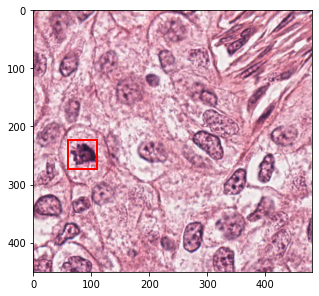

In [ ]:
train_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/'+train_dataset_folder
test_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/'+test_dataset_folder

print(train_dir)
print(test_dir)

dataset =      MitosisImagesDatasetTrain(train_dir, 481, 451)
dataset_test = MitosisImagesDatasetTest(test_dir, 481,451)

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[100]
print(img.shape)
plot_img_bbox(img, target)

In [ ]:
train_dataset =      MitosisImagesDatasetTrain(train_dir, 481, 451,transforms=get_transform(train=True))

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader  = DataLoader(train_dataset,batch_size=10,shuffle=True,num_workers=4,collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


#Training part

In [ ]:
num_classes=2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
# print(in_features)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model)

# model = model.to(device)

# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# num_epochs = 50

In [ ]:
print(train_dir)
print(test_dir)

/drive/MyDrive/CSE499 Project/Patch Datasets/Aperio ScanScope CS2/
/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu XR/


In [ ]:
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()